<a href="https://colab.research.google.com/github/top-data/Soil_moisture/blob/main/SM_modeling_surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To obtain access to the datasets used in this work you need to follow the following steps:
* Click on [this](https://drive.google.com/drive/u/1/folders/12cYWIfg_0wATfxxtnnhQfLHrghqazwj6) Google Drive folder link.

* Then, right click on the **SoilMoisture** folder and select **Add shortcut to Drive**.

![picture](https://drive.google.com/uc?id=1lZqtmeemmmCM7OZUj_kiqDMMvgGS375a)

* Make a shortcut of the **SoilMoisture** folder in your own **My Drive**-folder, by clicking on **Add shortcut**.

![picture](https://drive.google.com/uc?id=133aXjO2jrfMSj9lzK2aZNq69L6wEiKCH)

A new Google Drive folder with all the contents of this study has been linked to your Google Drive; therefore, we can link our Google Drive account to have access to the data.

# Connecting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading some libraries

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, LSTM, Concatenate, Reshape, Lambda, Permute, Dropout
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy import stats
import matplotlib.pyplot as plt

enc = OneHotEncoder(handle_unknown='ignore')

# Set a fixed seed for numpy and tensorflow to ensure reproducibility of the shuffling and splitting of data.
np.random.seed(42)
tf.random.set_seed(42)


## Connecting to reference data

In [3]:
Oznet_path = 'drive/MyDrive/SoilMoisture/oznet'
OzFlux_path = 'drive/MyDrive/SoilMoisture/ozflux'

oznet_data = [(os.path.join(Oznet_path, n), n) for n in os.listdir(Oznet_path) if n.startswith('comp2_')]
ozflux_data = [(os.path.join(OzFlux_path, n), n) for n in os.listdir(OzFlux_path) if n.startswith('comp2_')]
stations = oznet_data + ozflux_data

not_use = ['Longrea',  'ADwet_2', 'ADdry_2', 'jaxa'] #repeated or in NZ
stations = [(n, p) for n, p in stations if p[6:-4] not in not_use]

# SSMAP extent does not cover these stations
stations = [n for n in stations if ('CapeTri' not in n[1]) & ('CowBay' not in n[1])]


## Definition of some pre-processing and plotting functions

In [4]:
def split(dataframe, test_frac, train_frac, ran=None):
    '''
    Description: Splits the data into test, training and validation
    Inputs:
        dataframe: pandas dataframe
        test_frac: float
        train_frac: float
        ran: integer
    Outputs:
        test: pandas dataframe
        train: pandas dataframe
        validation: pandas dataframe
    '''
    dataframe.reset_index(inplace=True)
    test = dataframe.sample(frac=test_frac, random_state=0)
    training = dataframe.drop(test.index)
    training = training.sample(frac=1)
    train = training.sample(frac=train_frac, random_state=ran)
    validation = training.drop(train.index)
    return test.set_index('index'), train.set_index('index'), validation.set_index('index')


def split_train_vali(dataframe, test_frac, ran=0):
    '''
    Description: Splits the data into training and validation
    Inputs:
        dataframe: pandas dataframe
        test_frac: float
        ran: integer
    Outputs:
        vali: pandas dataframe
        train: pandas dataframe
    '''
    dataframe.reset_index(inplace=True)
    vali = dataframe.sample(frac=test_frac, random_state=ran)
    training = dataframe.drop(vali.index)
    train = training.sample(frac=1)
    return vali.set_index('index'), train.set_index('index')


def append_sm(dataframe, tuple_station, column=1):
    '''
    Description: Appends reference soil moisture to predictors dataframe
    Inputs:
        dataframe: pandas dataframe
        tuple_station: tuple with path to files and name of reference files
        column: integer corresponding to observation number
    Outputs:
        df: pandas dataframe
    '''
    test = pd.read_csv(tuple_station[0])#, encoding='latin1')
    cols = test.columns
    # test['dates'] = pd.to_datetime(test[cols[0]],format='%Y-%m-%d %H:%M:%S')

    test.rename(columns={cols[0]: 'dates'}, inplace=True)

    test['dates'] = pd.to_datetime(test['dates'], format='mixed')
    test['dates'] = test['dates'].dt.strftime('%Y-%m-%d %H:%M:%S')
    test['dates'] = pd.to_datetime(test['dates'], format='%Y-%m-%d %H:%M:%S')


    test = test.set_index('dates')
    test['sm'] = test[cols[column]].astype(float)

    test = test.dropna(subset=['sm'])

    resampled = test.resample('D').mean()
    resampled['sm'] = resampled['sm']/100
    df_sampled = dataframe[dataframe['id'].str.lower() == tuple_station[1][6:-4].lower()]
    df_sampledx = df_sampled.copy()
    df_sampledx['soilM'] = resampled['sm']
    df_sampledx[(df_sampledx['soilM'] < 0.0) |
                (df_sampledx['soilM'] > 1)] = np.nan
    df_sampledx[~df_sampledx.index.duplicated(keep='first')]
    df_sampledx = df_sampledx.dropna(subset=['id', 'soilM'])
    df_sampledx = df_sampledx.sort_index()
    return df_sampledx


def get_reference(tuple_station):
    '''
    Description: Creates pandas dataframe with reference data
    Inputs:
        tuple_station: tuple with path to files and name of reference files
    Outputs:
        resampled: pandas dataframe
    '''
    test = pd.read_csv(tuple_station[0])
    cols = test.columns
    test['dates'] = pd.to_datetime(test[cols[0]],
                                   format='%Y-%m-%d %H:%M:%S')
    test = test.set_index('dates')
    test['sm'] = test[cols[1]].astype(float)
    resampled = test.resample('D').mean()

    resampled['sm'] = resampled['sm']/100
    mask = (resampled.index >= '2016-01-01') & (resampled.index < '2020-12-31')
    resampled = resampled[mask]
    resampled[(resampled['sm'] < 0.0) |
              (resampled['sm'] > 1)] = np.nan
    return resampled


def plot(tuple_station, column):
    '''
    Description: Plots the reference data time series
    Inputs:
        tuple_station: tuple with path to files and name of reference files
        column: integer corresponding to observation number
    Outputs:
        matplotlib time series plot
    '''
    test = pd.read_csv(tuple_station[0])
    cols = test.columns
    test['dates'] = pd.to_datetime(test[cols[0]],
                                   format='%Y-%m-%d %H:%M:%S')
    test = test.set_index('dates')
    test['sm'] = test[cols[column]].astype(float)
    resampled = test.resample('D').mean()
    resampled['sm'] = resampled['sm']/100
    mask = (resampled.index >= '2016-01-01') & (resampled.index < '2020-04-01')
    resampled = resampled[mask]
    resampled[(resampled['sm'] < 0.0) |
              (resampled['sm'] > 1)] = np.nan
    plt.plot(resampled.index, resampled.sm, label='observed')
    plt.title(tuple_station[1][6:-4])
    plt.tick_params(axis='x', rotation=30)


def plot_predictions(df, tuple_station, model, variables, column=1):
    '''
    Description: Plots the reference data time series and model predictions
    Inputs:
        df: pd predictors dataframe
        tuple_station: tuple with path to files and name of reference files
        column: integer corresponding to observation number
        model: tf trained model
        variables: list of predictor variables
    Outputs:
        matplotlib time series plot
    '''
    plot(tuple_station, column)
    df['id'] = df['id'].str.lower()
    DFsub = df[df['id'] == tuple_station[1][6:-4].lower()]
    DFsub['pred'] = model.predict(DFsub[variables].values.reshape((DFsub[variables].shape[0],
                                                                   DFsub[variables].shape[1],
                                                                   1)))

    DFsub['date'] = pd.to_datetime(DFsub['date'], format='%Y-%m-%d')
    DFsub = DFsub.set_index('date')
    plt.scatter(DFsub.index, DFsub['pred'], marker='x', c='red', label='predicted')


## Defining modelling functions

In [5]:
def ccc(y_true, x_true):
    '''
    Description: Creates ccc loss function for tf model
    Inputs:
        y_true: predictions
        x_true: observations
    Outputs:
        ccc loss function
    '''
    uy, ux = K.mean(y_true), K.mean(x_true)
    sxy = tfp.stats.covariance(y_true, x_true)
    sy, sx = tfp.stats.variance(y_true), tfp.stats.variance(x_true)
    E = 2*sxy/(sy+sx+K.pow(uy-ux, 2))
    return 1-E


def crop(dimension, start, end):
    '''
    Description: Crops (or slices) a Tensor on a given dimension from start to end
    Inputs:
        start: integer
        end: integger
        dimension: integer with dimensions
    Outputs:
        lambda function
    '''
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)


def modl(inputs):
    '''
    Description: Creates a combined LSTM and MLP tf model
    Inputs:
        inputs: list of inputs
    Outputs:
        tf model
    '''
    input = Input(shape=(len(inputs), 1), dtype='float32')
    slice1 = crop(1, 0, int(len(lstm_cols)))(input)
    reshaped = Reshape((3, int(len(lstm_cols)/3)), input_shape=(int(len(lstm_cols)), 1))(slice1)
    lstm_input = Permute((2, 1), input_shape=(3, int(len(lstm_cols)/3)))(reshaped)
    hidden1 = LSTM(200, activation='relu')(lstm_input)
    slice2 = crop(1, int(len(lstm_cols)), len(var_in))(input)
    slice2 = Reshape((len(var_in) - int(len(lstm_cols)), ),
                     input_shape=(len(var_in) - int(len(lstm_cols)), ))(slice2)
    x = Concatenate()([hidden1, slice2])
    hidden3 = Dense(128, activation='relu')(x)
    hidden4 = Dense(64, activation='relu')(hidden3)
    hidden5 = Dense(32, activation='relu')(hidden4)
    hidden6 = Dense(16, activation='relu')(hidden5)
    mlp_out = Dense(1, activation=lambda x: relu(x, max_value=1.0))(hidden6)

    model = Model(inputs=input, outputs=mlp_out)
    model.compile(loss=ccc, optimizer=Adam(learning_rate=0.00003))
    return model


def mlp(inputs):
    '''
    Description: Creates a MLP tf model
    Inputs:
        inputs: list of inputs
    Outputs:
        tf model
    '''
    input = Input(shape=(len(inputs)), dtype='float32')
    hidden3 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    hidden3 = Dropout(0.3)(hidden3)
    hidden4 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(hidden3)
    hidden4 = Dropout(0.3)(hidden4)
    hidden5 = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(hidden4)
    hidden5 = Dropout(0.3)(hidden5)
    hidden6 = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(hidden5)
    hidden6 = Dropout(0.3)(hidden6)
    mlp_out = Dense(1, activation=lambda x: relu(x, max_value=1.0))(hidden6)

    model = Model(inputs=input, outputs=mlp_out)
    model.compile(loss=ccc, optimizer=Adam(learning_rate=0.00003))
    return model


def leave_one_out(probe, dataframe, inputs, model,  stations):
    '''
    Description: Returns trained tf model with leave one out cross validation
    Inputs:
        probe: string of station left out
        dataframe: predictors dataframe
        inputs: list of inputs
        model: tf model
        stations: list of strings (station names)
    Outputs:
        mdl: trained tf model
        here: dictionary with history of training
        DFvali: pd dataframe subset for validation subset
        DFtest: pd dataframe subset for test subset based on probe
    '''
    DFs = dataframe.copy()
    DFs = DFs.dropna(how='any')
    DFs = DFs.sample(frac=1)
    DFs1 = DFs[inputs]
    DFs1 = DFs1.apply(lambda x: (x - x.min())/(x.max() - x.min()))
    DFs1['soilM'], DFs1['date'], DFs1['id'] = DFs['soilM'], DFs['date'], DFs['id']
    stations_rem = [n for n in stations if n != probe]
    vali_ix = np.random.randint(0, len(stations_rem))
    vali_station = stations[vali_ix]
    DFtrain = DFs1[(DFs1['id'] != probe) & (DFs1['id'] != vali_station)]
    DFvali = DFs1[DFs1['id'] == vali_station] # for early stop and fine tuning
    DFtest = DFs1[DFs1['id'] == probe] # for performance
    tr_in = DFtrain[inputs].values.reshape((DFtrain[inputs].shape[0],
                                            DFtrain[inputs].shape[1],
                                            1))
    tr_out = DFtrain['soilM'].values
    tr_in, tr_out = tr_in.astype('float32'), tr_out.astype('float32')
    va_in = DFvali[inputs].values.reshape((DFvali[inputs].shape[0],
                                           DFvali[inputs].shape[1],
                                           1))
    va_out = DFvali['soilM'].values
    va_in, va_out = va_in.astype('float32'), va_out.astype('float32')
    mdl = model(inputs)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    here = mdl.fit(tr_in.reshape((tr_in.shape[0], tr_in.shape[1])),
                   tr_out,
                   epochs=500,
                   verbose=2,
                   batch_size=256,
                   validation_data=(va_in.reshape((va_in.shape[0], va_in.shape[1])), va_out),
                   callbacks=[callback])
    return mdl, here, DFvali, DFtest


def model_whole(dataframe, inputs, model, test_frac):
    '''
    Description: Returns trained tf model with traning and validation split for SHAP
    Inputs:
        dataframe: predictors dataframe
        inputs: list of inputs
        model: tf model
        test_frac: float
    Outputs:
        mdl: trained tf model
        here: dictionary with history of training
        tr_in: pd dataframe subset for training
        vali_in: pd dataframe subset for validation
        DFs1: pd dataframe for predictors
    '''
    DFs = dataframe.copy()
    DFs = DFs.dropna(how='any')
    DFs = DFs.sample(frac=1)
    DFs1 = DFs[inputs]
    DFs1 = DFs1.apply(lambda x: (x - x.min())/(x.max() - x.min()))
    DFs1['soilM'], DFs1['date'], DFs1['id'] = DFs['soilM'], DFs['date'], DFs['id']
    vali, train = split_train_vali(DFs1, test_frac, ran=0)
    tr_in = train[inputs].values.reshape((train[inputs].shape[0],
                                          train[inputs].shape[1],
                                          1)).astype('float32')
    vali_in = vali[inputs].values.reshape((vali[inputs].shape[0],
                                           vali[inputs].shape[1],
                                           1)).astype('float32')
    tr_out, vali_out = train['soilM'].values.astype('float32'), vali['soilM'].values.astype('float32')
    mdl = model(inputs)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    here = mdl.fit(tr_in.reshape((tr_in.shape[0], tr_in.shape[1])),
                   tr_out,
                   epochs=500,
                   verbose=2,
                   batch_size=256,
                   validation_data=(vali_in.reshape((vali_in.shape[0], vali_in.shape[1])), vali_out),
                   callbacks=[callback])
    return mdl, here, tr_in, vali_in, DFs1[inputs]


def model_khold(dataframe, inputs, model, test_frac, train_frac):
    '''
    Description: Returns trained tf model splitting into test, training, and validation
    Inputs:
        dataframe: predictors dataframe
        inputs: list of inputs
        model: tf model
        test_frac: float
        train_frac: float
    Outputs:
        mdl: trained tf model
        here: dictionary with history of training
        vali_in: pd dataframe subset for validation
        DFs1: pd dataframe for predictors
    '''
    DFs = dataframe.copy()
    DFs = DFs.dropna(how='any')
    DFs = DFs.sample(frac=1)
    DFs1 = DFs[inputs]
    DFs1 = DFs1.apply(lambda x: (x - x.min())/(x.max() - x.min()))
    DFs1['soilM'], DFs1['date'], DFs1['id'] = DFs['soilM'], DFs['date'], DFs['id']
    te, tr, va = split(DFs1, test_frac, train_frac, ran=42)
    tr_in = tr[inputs].values.reshape((tr[inputs].shape[0],
                                       tr[inputs].shape[1],
                                       1)).astype('float32')
    vali_in = va[inputs].values.reshape((va[inputs].shape[0],
                                         va[inputs].shape[1],
                                         1)).astype('float32')
    tr_out, vali_out = tr['soilM'].values.astype('float32'), va['soilM'].values.astype('float32')
    mdl = model(inputs)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    here = mdl.fit(tr_in.reshape((tr_in.shape[0], tr_in.shape[1])),
                   tr_out,
                   epochs=500,
                   verbose=2,
                   batch_size=256,
                   validation_data=(vali_in.reshape((vali_in.shape[0], vali_in.shape[1])), vali_out),
                   callbacks=[callback])
    return mdl, here, tr_in, vali_in, DFs1[inputs]


## Defining funtions to assess modelling

In [6]:
def plot_learning(history):
    '''
    Description: Creates learning curve plot
    Inputs:
        history: dictionary with training loss
    Outputs:
        learning curve matplotlib plot
    '''
    plt.plot(range(len(history.history['val_loss'])),
             history.history['loss'],
             label='train')
    plt.plot(range(len(history.history['val_loss'])),
             history.history['val_loss'],
             label='validation')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(r'Loss $(1 - \rho_c)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', labelsize=12)


def add_predictions(df, model, inputs):
    '''
    Description: Adds predictions column to dataframe
    Inputs:
        df: pandas dataframe
        model: tf model
        inputs: list of predictors
    Outputs:
        df: pandas dataframe
    '''
    predictions = model.predict(df[inputs].values.reshape((df.shape[0],
                                                           df[inputs].shape[1],
                                                           1)))
    df['pred'] = predictions
    return df


def add_predictions2(df, model, inputs):
    predictions = model.predict(df[inputs].values)
    df['pred'] = predictions
    return df


def plot_performance(df):
    '''
    Description: Creates performance plot with metrics
    Inputs:
        df: pandas dataframe
    Outputs:
        matplotlib plot
    '''
    rmse = np.mean((df['soilM'] - df['pred'])**2)**0.5
    slope, intercept, r, p_value, std_err = stats.linregress(df['soilM'],
                                                             df['pred'])
    plt.scatter(df['soilM'], df['pred'], alpha=0.3)
    plt.plot(np.linspace(0, 1.5, 100),
             np.linspace(0, 1.5, 100),
             linestyle='--',
             color='black')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel(r'Observed $\theta$', fontsize=14)
    plt.ylabel(r'Predicted $\theta$', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.text(0.05, 0.85, 'RMSE = {}\nR² = {}'.format(str(np.round(rmse, 3)),
                                                     str(np.round(r**2, 3))),
             fontsize=12)


def plot_series(station, column=1):
    '''
    Description: Creates time series plot for stations
    Inputs:
        station: string
        column: observation number
    Outputs:
        matplotlib plot
    '''
    data_ref = [n for n in stations if n[1][6:-4] == station]
    check = pd.read_csv(data_ref[0][0])
    cols = check.columns
    if 'oznet' in data_ref[0][0]:
        check = check.set_index(pd.to_datetime(check['dates'], format='%Y-%m-%d %H:%M:%S'))
    else:
        check = check.set_index(pd.to_datetime(check['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S'))
    check['sm'] = check[cols[column]].astype(float)
    check = check.resample('D').mean()
    check[(check['sm']<0) | (check['sm']>100)] = np.nan
    check['sm'] = check['sm']/100
    check = check[(check.index > '2016-01-01')]
    plt.plot(check.index, check['sm'], label='observed')


def station_series(model, df, inputs, stations, ix):
    '''
    Description: Returns figure of reference data time series and model predictions
    Inputs:
        model: tf trained model
        df: pd predictors dataframe
        inputs: list of predictor variables
        stations: list of station tuples
        ix: integer index
    Outputs:
        matplotlib figure
    '''
    figure = plt.figure()
    test = plot_predictions(df, stations[ix], model, inputs)
    plt.ylabel('$\\theta$  (cm$^3$ cm$^{-3}$)', fontsize=14)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(fontsize=13)
    plt.show()


## Toy example

### Loading predictors

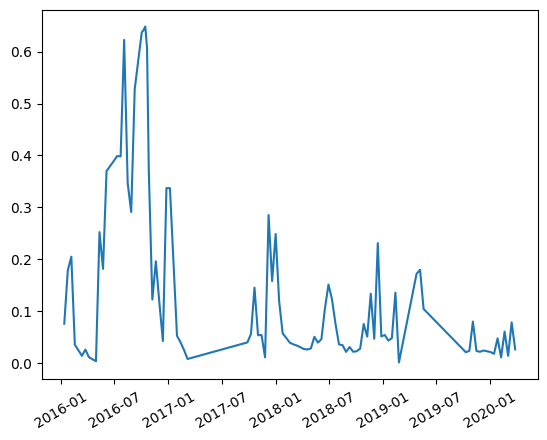

In [35]:
plt.plot(dfs[42].index, dfs[42].soilM)
plt.xticks(rotation=30)
plt.show()

In [7]:
df = pd.read_csv('drive/MyDrive/SoilMoisture/soil_moist_inputs.csv')
df.drop(['.geo'], inplace=True, axis=1)
df.set_index(pd.to_datetime(df['date'], format='%Y-%m-%d'), inplace=True)
df.dropna(how='any', inplace=True)
dfs = [append_sm(df, n) for n in stations]

### Setting covariate and prediction names

In [8]:
ixs = range(1, 11)
smap_cols = ['smap{}'.format(str(n)) for n in ixs]
ssmap_cols = ['ssmap{}'.format(str(n)) for n in ixs]
chirps_cols = ['chirps{}'.format(str(n)) for n in ixs]

lstm_cols = smap_cols+chirps_cols+ssmap_cols

mlp_cols = [#'hnd', 'upa',
            'VV', 'rSSM',
            'AWC1', 'AWC2', 'AWC3', 'AWC4',
            'CLY1', 'CLY2', 'CLY3', 'CLY4',
            'SOC1', 'SOC2', 'SOC3', 'SOC4',
            'LST_Day_1km', 'LST_Night_1km',
            'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
            'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07',
            'NDVI', 'irri', 'past', 'agri', 'fore', 'sava']

var_in = lstm_cols + mlp_cols
var = var_in.copy()
var_y = 'soilM'
var.append(var_y)

### Setting predictors dataframe (land use to one hot encode)

In [9]:
DF = pd.concat(dfs)
DF.drop('date', axis=1, inplace=True)
DF = DF.reset_index()

DF.loc[(DF['LU'] == 7), 'LU'] = 2

DF.loc[(DF['LU'] == 11), 'LU'] = 1  # changed wetland to pasture
DF.loc[(DF['LU'] == 9), 'LU'] = 10  #shrubland (1) to savanna
enc_df = pd.DataFrame(enc.fit_transform(DF[['LU']]).toarray())
enc_df.rename(columns={0: 'irri', 1: 'past', 2: 'agri', 3: 'fore', 4: 'sava'}, inplace=True)
DF = DF.join(enc_df)

statio = DF['id'].unique().tolist()

## Running one model test and plot learning curve

Epoch 1/500
27/27 - 2s - loss: 1.2044 - val_loss: 1.2271 - 2s/epoch - 84ms/step
Epoch 2/500
27/27 - 0s - loss: 1.2128 - val_loss: 1.2324 - 123ms/epoch - 5ms/step
Epoch 3/500
27/27 - 0s - loss: 1.1945 - val_loss: 1.2349 - 128ms/epoch - 5ms/step
Epoch 4/500
27/27 - 0s - loss: 1.1727 - val_loss: 1.2423 - 127ms/epoch - 5ms/step
Epoch 5/500
27/27 - 0s - loss: 1.1514 - val_loss: 1.2282 - 141ms/epoch - 5ms/step
Epoch 6/500
27/27 - 0s - loss: 1.1327 - val_loss: 1.1912 - 129ms/epoch - 5ms/step
Epoch 7/500
27/27 - 0s - loss: 1.1061 - val_loss: 1.1320 - 147ms/epoch - 5ms/step
Epoch 8/500
27/27 - 0s - loss: 1.0999 - val_loss: 1.0289 - 142ms/epoch - 5ms/step
Epoch 9/500
27/27 - 0s - loss: 1.0726 - val_loss: 0.9184 - 128ms/epoch - 5ms/step
Epoch 10/500
27/27 - 0s - loss: 1.0168 - val_loss: 0.8610 - 134ms/epoch - 5ms/step
Epoch 11/500
27/27 - 0s - loss: 1.0088 - val_loss: 0.8129 - 134ms/epoch - 5ms/step
Epoch 12/500
27/27 - 0s - loss: 0.9879 - val_loss: 0.7830 - 146ms/epoch - 5ms/step
Epoch 13/500
27

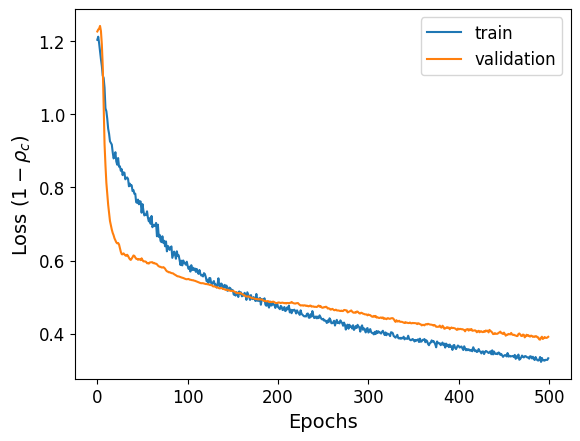

In [10]:
model, here, DFvali, DFtest = leave_one_out(statio[42], DF, var_in, mlp, statio)

plot_learning(here)
plt.show()



### plotting performance

3/3 [==============================] - 0s 5ms/step


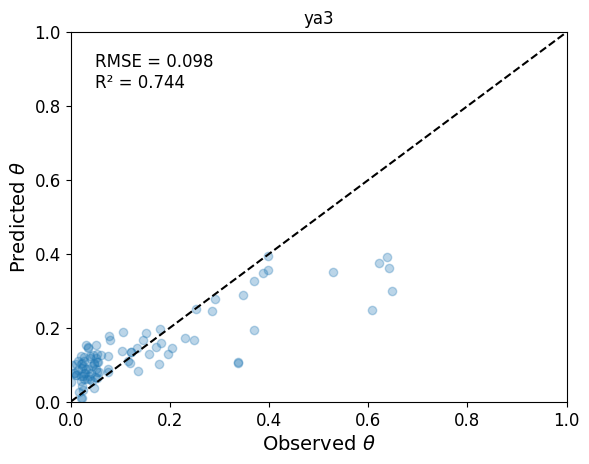

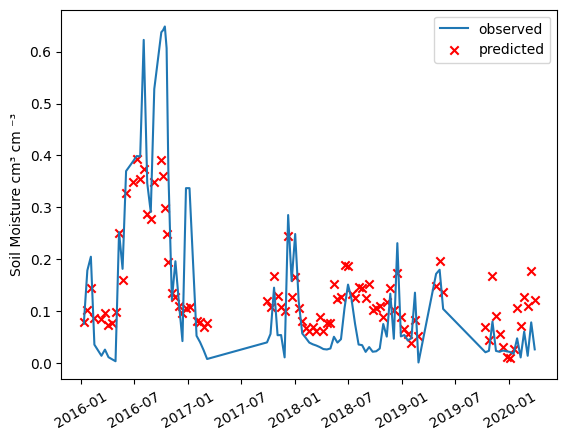

In [37]:
DFtest = add_predictions(DFtest, model, var_in)
plot_performance(DFtest)
plt.title(statio[42])
plt.show()


DFtest = DFtest.set_index(pd.to_datetime(DFtest['date']))
DFtest.sort_index(inplace=True)
DFtest['soilM']
plt.plot(DFtest['soilM'], label='observed')
plt.scatter(DFtest.index, DFtest['pred'], color='red', marker='x', label='predicted')
# plt.ylim(0, 0.6)
plt.xticks(rotation=30)
plt.ylabel('Soil Moisture cm³ cm ⁻³')
plt.legend()
plt.show()